In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create Engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
past_year = dt.date(2016, 8, 24)
#print(past_year)
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last_date)
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, func.avg(Measurement.prcp).label("avg_prcp")).filter(Measurement.date >= past_year).group_by(Measurement.date).order_by(Measurement.date).all()
rain

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [8]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.set_index('date')
rain_df.head()
# Sort the dataframe by date


,date,avg_prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


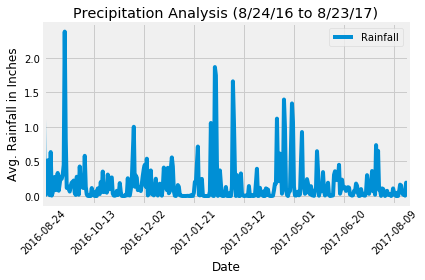

In [9]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'avg_prcp')
plt.xlabel("Date")
plt.ylabel("Avg. Rainfall in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Rainfall"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Images/RainfallPastYearPlot.png")
plt.show()


In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,avg_prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [11]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {stations} stations in this dataset.")

There are 9 stations in this dataset.


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

most_active = active_station[0][0]
print(f"The most active station is {most_active}, with {active_station[0][1]} measurements recorded.")

The most active station is USC00519281, with 2772 measurements recorded.


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs).label("Lowest Temperature"), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all() 

[(54.0, 85.0, 71.66378066378067)]

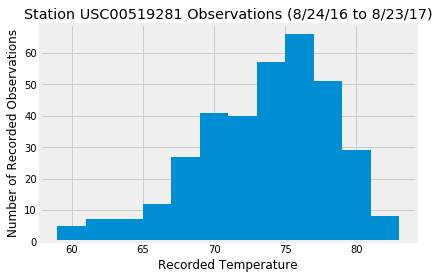

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > past_year).\
    order_by(Measurement.date).all()

to_df = pd.DataFrame(temp_observations)
plt.hist(to_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station " + most_active + " Observations (8/24/16 to 8/23/17)")
plt.savefig("Images/MostObersationsBarChart.png")
plt.show()

## Bonus Challenge Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-03-17', '2017-03-22')
trip

[(65.0, 72.57142857142857, 77.0)]

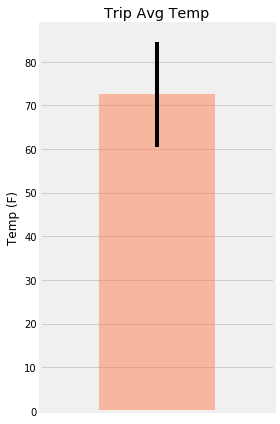

In [17]:
#Create a Data Frame with the calculated values
trip_df = pd.DataFrame(trip, columns=["TMin","TAvg","TMax"])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='TAvg', yerr=(trip_df['TMax'] - trip_df['TMin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-03-17','2017-03-22'))

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.35), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.19), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.12), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None)]


In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("08-24")

[(70.0, 75.96153846153847, 84.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Set the start and end date of the trip
start_date = '2017-03-17'
end_date ='2017-07-22'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Strip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [
    session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
    filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
    group_by(func.strftime("%m-%d", Measurement.date)).all()
]

normals = normals[0]
print("Aggregate Daily Normals for 03-17 to 03-22")
normals

Aggregate Daily Normals for 03-17 to 03-22


[(57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0),
 (61.0, 71.875, 79.0),
 (60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0),
 (62.0, 71.55357142857143, 81.0),
 (65.0, 71.93103448275862, 77.0),
 

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
normals_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')

# Set index to date
normals_df.set_index('date',inplace=True)

normals_df

,tmin,tavg,tmax
date,,,
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0
2017-03-20,62.0,70.117647,80.0
2017-03-21,60.0,71.076923,77.0
...,...,...,...
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0
2017-07-20,69.0,75.462963,82.0


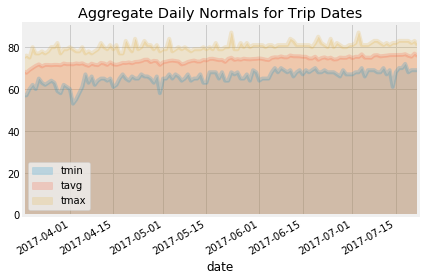

In [22]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/NormalsAreaPlot.png")
plt.show()